### Adapatación código GEE 


Codigo en GEE, Escrito por Pedro Rodriguez-Veiga
Adaptado a python por Yilsey Benavides Miranda para el CDCol IDEAM 
//Organization: National Centre for Earth Observation - University of Leiceicester (UK)
//In colaboration with: IDEAM - Institute of Hydrology, Meteorology and Environmental Studies (Colombia)
//Purpose: Development / testing Colombia's aboveground biomass map algorithm
//Current version: 4.1
//Improvements version 4.1:
//   - AGB estimated using Chave et al. and Alvarez et al. type I allometries
//   - Co-registration ALOS-2 PALSAR-2 composite to Sentinel-1
//   - The k-fold cross-validation was converted to loop functions
//   - The PPM validation is now completely independent (the corresponding conglomerados within the the same location are not used for cal/val)
//   - Error propagation on the uncertainty layer (RMSE or Rel_RMSE)

### Librerías

In [2]:
import datacube
from datacube.storage import netcdf_writer
from datacube.model import Variable, CRS
import os
import re
import xarray as xr
import numpy as np
import gdal
from sklearn.datasets import make_regression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.utils.multiclass import unique_labels
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal,ogr
from glob import glob
import matplotlib as mpl


/home/cubo/anaconda/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Definición de funciones

In [3]:
def exportar(fname, data, geo_transform, projection):
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None

In [4]:
def rasterizar_entrenamiento(plyr, pValFilter, pAttrFil, pAttrAGB, rows, cols , geo_transform, projection):
    labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a llenar
    plyr.SetAttributeFilter(pAttrFil + " <> " + "'" + str(pValFilter) + "'")  #### Con este filtra
    print("Nro de Pol Filtrados  <> de",str(pValFilter),":", plyr.GetFeatureCount())
    pClasesAGB = []
    for feature in plyr:
        pClasesAGB.append(feature.GetField(pAttrAGB))
        pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
    print(pClasesAGB) #Imprime la cantida de valores de AGB encontrados en el shapefile removiendo los duplicados
    for val in pClasesAGB:
        plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  # Con este filtra el valor correspondiente al agb a estimar
        print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
        driver = gdal.GetDriverByName('MEM')
        target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
        target_ds.SetGeoTransform(geo_transform)
        target_ds.SetProjection(projection)
        gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
        band = target_ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
    return labeled_pixels

In [5]:
def ValidarClass(plyr, pValFilter, pAttrFil, pAttrAGB, geo_transform, projection, kFoldImg):
        rows, cols = kFoldImg.shape
        labeled_pixels = np.zeros((rows, cols)) # imagen base de zeros donde empieza a almacenar
        plyr.SetAttributeFilter(pAttrFil + " = " + "'" + str(pValFilter) + "'")  #Con este filtra el valor del atributo de kfold del shapefile
        print("Nro Poligonos para el Kfold", str(pValFilter), " = ", plyr.GetFeatureCount())
        pClasesAGB = []
        for feature in plyr:
             pClasesAGB.append(feature.GetField(pAttrAGB))
        pClasesAGB = list(dict.fromkeys(pClasesAGB)) # remueve Duplicados si hay dos o mas poligonos con el mismo AGB
        for val in pClasesAGB:
            plyr.SetAttributeFilter(pAttrAGB + " = " + str(val))  #### Con este filtra
            print("AGB:", val , "nroPol:", plyr.GetFeatureCount())
            driver = gdal.GetDriverByName('MEM')
            target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
            target_ds.SetGeoTransform(geo_transform)
            target_ds.SetProjection(projection)
            gdal.RasterizeLayer(target_ds, [1], plyr, burn_values=[val]) ## Asigna el valor de label al poligono 
            band = target_ds.GetRasterBand(1)
            ###Inicio de Validación el poligono contra los datos del shape
            pImgPol = np.array(band.ReadAsArray())
            pClassImaKfold = np.array(kFoldImg)
            n_samples = rows*cols
            #Comparación entre el valor registrado en la tabla del shapefile y el valor estimado en la imagen clasificada
            imagRes = np.where(pImgPol.reshape((n_samples, 1)) > 0, pClassImaKfold.reshape((n_samples, 1)), 0) 
            print("AGB en Shp: ", str(val),"Media Calculada:", np.mean(imagRes[imagRes != 0]))#Imprime el comparativo de los valores estimados y los valores registrados en el shapefile
            labeled_pixels += imagRes.reshape((rows, cols))#Almacenamiento de pixel validados
        return labeled_pixels


### Definción de Consulta

#### Parámetros de Consulta

In [6]:
execID=1
algorithm = "RandomForestReg"
version= "1.0"

##### Los parametros que encontrará a continuación corresponde 

- products = Unidad de almacenamiento que desea consultar (Sátelite), Landsat 5, 7 y 8 
- bands = Las bandas que desea emplear para el calculo de medianas y los índices que encontrará debajo  de la función de medianas
- time_ranges = Rango o periodo de tiempo a cosultar (Veriricar que corresponda a los datos disponibles por unidad de almacenamiento)
- Área = El usuario debe definir la longitud mínima, máxima y la latitud mínima, máxima del área de consulta
- normalized = Función para normalizar los valores resultantes del cálculo de las medianas
- minValid = Valor mínimo valido que empleará el algoritmo  para el cálculo de las medianas
- nodata= -9999 Es el valor por defecto que se dará a los valores no data en el cálculo de las medianas

In [7]:
products = ['LS8_OLI_LASRC'] #Productos sobre los que se hará la consulta (unidades de almacenamiento)
bands=["red","nir", "swir1","swir2","green","blue"] #arreglo de bandas #"blue","green",
time_ranges = [("2016-01-01", "2016-02-25")] #Una lista de tuplas, cada tupla representa un periodo
#área sobre la cual se hará la consulta:
min_long = -71
min_lat = 4
max_long = -70
max_lat = 5

In [8]:
normalized=True
minValid=1;

nodata=-9999

In [9]:
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))

#### Función de Consulta de unidad de almacenamiento Landsat con parámetros asignados

In [10]:
kwargs={}
dc = datacube.Datacube(app="{}_{}_{}".format(algorithm,version,execID))
for product in products:
    i=0
    validValues=set()
    if product=="LS7_ETM_LEDAPS":
        validValues=[66,68,130,132]
    elif product == "LS8_OLI_LASRC":
        validValues=[322, 386, 834, 898, 1346, 324, 388, 836, 900, 1348]
    for tr in time_ranges:
        _data = dc.load(product=product, longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=tr)
        if len(_data.data_vars)==0:
            break
        cloud_mask=np.isin(_data["pixel_qa"].values, validValues)
        for band in bands:
            _data[band].values=np.where(np.logical_and(_data.data_vars[band]!=nodata,cloud_mask),_data.data_vars[band], np.nan)
        _undesired=list(set(_data.keys())-set(bands+['latitude','longitude','time']))
        _data=_data.drop(_undesired)
            
        if "xarr"+str(i) in kwargs:
            kwargs["xarr"+str(i)]=xr.concat([kwargs["xarr"+str(i)],_data.copy(deep=True)], 'time')
        else:
            kwargs["xarr"+str(i)]=_data
    i+=1
del _data

/home/cubo/anaconda/lib/python3.6/_collections_abc.py:720: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  yield from self._mapping


In [11]:
#El algoritmo recibe los productos como xarrays en variablles llamadas xarr0, xarr1, xarr2... 
xarr0=kwargs["xarr0"]
del kwargs

#### Función de Consulta de unidad de almacenamiento Radar ALOS PALSAR


Se consultará la misma área y rango de tiempo asignadas en los parametros iniciales

In [12]:
_data3 = dc.load(product="ALOS2_PALSAR_MOSAIC", longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=("2016-01-01", "2016-12-31"))

In [13]:
#Almacenar los valores de las bandas en el xarr0 construido en la consulta anterior
xarr0['hh']=_data3['hh']
xarr0['hv']=_data3['hv']

#### Función de Consulta de unidad de almacenamiento Bosque No Bosque


Se consultara la misma área y rango de tiempo asignadas en los parametros iniciales

In [16]:
_data4 = dc.load(product="FNF_COL_UTM", longitude=(min_long, max_long), latitude=(min_lat, max_lat), time=("2016-01-01", "2016-12-31"))

#### Función de Cálculo de Índices para unidad de alamacenamiento RADAR ALOS PALSAR

In [17]:
banda1=_data3['hh']
banda2=_data3['hv']

In [18]:
#Cálculo del 1er RDFI índice Radar Forest Degradation  para ALOS PALSAR
RDFI =(banda1-banda2)/(banda1+banda2)

In [19]:
RDFI

<xarray.DataArray (time: 1, latitude: 3687, longitude: 3704)>
array([[[0.343135, 0.306258, ..., 0.489631, 0.451856],
        [0.393745, 0.316515, ..., 0.385504, 0.429953],
        ...,
        [0.293223, 0.293061, ..., 0.2672  , 0.282529],
        [0.301297, 0.295617, ..., 0.287374, 0.274844]]])
Coordinates:
  * time       (time) datetime64[ns] 2016-01-01
  * latitude   (latitude) float64 5.0 5.0 4.999 4.999 4.999 4.999 4.998 ...
  * longitude  (longitude) float64 -71.0 -71.0 -71.0 -71.0 -71.0 -71.0 -71.0 ...

In [20]:
#Cálculo de indices CPR Circular Polarization ratio y LPR Linear Polarization Ratio para ALOS PALSAR
s1  = (banda1+banda2)
s2  =(banda1-banda2)
s3 = 2 * (banda1 **(1/2))*(banda2 **(1/2)) * np.cos(banda1-banda2)
s4 =2 * (banda1 **(1/2))*(banda2 **(1/2)) * np.sin(banda1-banda2)
LPR =(s1+s2)/(s1-s2)
SC = 0.5*s1 - 0.5 * s4
OC = 0.5*s1 + 0.5 * s4
CPR =(SC/OC)
m = (((s2**2)+(s3**2)+(s4**2))**(1/2))/s1

#### Función cálculo de medianas de la consulta anterior 

Generación de un compuesto temporal de medianas de las unidades consultados al inicio, obteniendo una salida del rango de tiempo consultado

In [21]:
medians={} 
for band in bands:
    datos=xarr0[band].values
    allNan=~np.isnan(datos) #Una mascara que indica qué datos son o no nan. 
    if normalized: #Normalizar, si es necesario.
        #Para cada momento en el tiempo obtener el promedio y la desviación estándar de los valores de reflectancia
        m=np.nanmean(datos.reshape((datos.shape[0],-1)), axis=1)
        st=np.nanstd(datos.reshape((datos.shape[0],-1)), axis=1)
        # usar ((x-x̄)/st) para llevar la distribución a media 0 y desviación estándar 1, 
        # y luego hacer un cambio de espacio para la nueva desviación y media. 
        datos=np.true_divide((datos-m[:,np.newaxis,np.newaxis]), st[:,np.newaxis,np.newaxis])*np.nanmean(st)+np.nanmean(m)
    #Calcular la mediana en la dimensión de tiempo 
    medians[band]=np.nanmedian(datos,0) 
    #Eliminar los valores que no cumplen con el número mínimo de pixeles válidos dado. 
    medians[band][np.sum(allNan,0)<minValid]=np.nan
    
del datos

/home/cubo/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


In [22]:
# Dimensiones de filas y columnas que empleará el algoritmo para definir su salida final
rows, cols = medians[bands[0]].shape

#### Cálculo de índices a partir de la consulta de medianas realizada anteriormente

Cálculo de índices a partir del compuesto temporal de medianas generado empleando indices de vegetacion e incorporando los indices de radar anteriormente generados con la unidad de almacenamiento ALOS PALSAR

In [23]:
medians["ndvi"]=(medians["nir"]-medians["red"])/(medians["nir"]+medians["red"])

In [24]:
medians["ndmi"]=(medians["nir"]-medians["swir1"])/(medians["nir"]+medians["swir1"])

In [25]:
medians["nbr"]=(medians["nir"]-medians["swir2"])/(medians["nir"]+medians["swir2"])

In [26]:
medians["nbr2"]=(medians["swir1"]-medians["swir2"])/(medians["swir1"]+medians["swir2"])

In [27]:
medians["savi"]=(medians["nir"]-medians["red"])/(medians["nir"]+medians["red"]+1)*2 

In [28]:
medians['rdfi']=RDFI[0].values

In [29]:
medians['cpR']=CPR[0].values

In [30]:
medians['hh']=banda1[0].values

In [31]:
medians['hv']=banda2[0].values

In [32]:
#Lista de bandas del arreglo cálculado 
bands=list(medians.keys())
bands

['red',
 'nir',
 'swir1',
 'swir2',
 'green',
 'blue',
 'ndvi',
 'ndmi',
 'nbr',
 'nbr2',
 'savi',
 'rdfi',
 'cpR',
 'hh',
 'hv']

In [33]:
#Registro de sistema de referencia y coordenadas del arreglo que posteriormente el algoritmo emplea en la salida
_coords=xarr0.coords
_crs=xarr0.crs

In [34]:
#Registro de sistema de referencia y coordenadas del arreglo que posteriormente el algoritmo emplea en la salida
geo_transform=(_coords["longitude"].values[0], 0.000269995,0, _coords["latitude"].values[0],0,-0.000271302)
proj=_crs.wkt

### Clasificación y regresión de Random Forest


#### Preparación insumos vector
shapeFileCorte= Se refiere a la carpeta que contiene los shapefile de entrenamiento del para la clasificación

Dentro de la función de rasterización de los valores de AGB cálculado por chavez se asigna al campo "pAttrAGB" la columna correspondiente dentro del shapefile para el ejemplo corresponde a "cha_HD", para la discriminación de valores por kfold se deberá asignar el attributo "pAttributo" que dentro del shapefile contiene el valor de kfold para cada poligono para el ejemplo es "k10"


In [35]:
shapeFileCorte = r'/home/cubo/jupyter/Biomasa/ipcc/'
ds=ogr.Open(shapeFileCorte)
lyr=ds.GetLayer()
print(lyr)
pAttributo = 'K10'
pAttrAGB = 'cha_HD'
print("Nro poligonos en Shape:",lyr.GetFeatureCount())
pClasesName = []
       #lee todos los poligonos para extraer el numero de clases en el arreglo 
for feature in lyr:
    pClasesName.append(feature.GetField(pAttributo))
    pClasesName = list(dict.fromkeys(pClasesName)) # remueve Duplicados
print(pClasesName)
proj='GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'


<osgeo.ogr.Layer; proxy of <Swig Object of type 'OGRLayerShadow *' at 0x7fa489a4cb40> >
Nro poligonos en Shape: 6
[0.0, 5.0, 9.0]


In [36]:
#Lista de valores de AGB encontrados en el shapefile de insumo
pClasesName

[0.0, 5.0, 9.0]

In [37]:
###Se procede a realizar  la rasterización de los poligonos ingresados definidos con los parámetros anteriormente
ImagesTrain = []
for K in pClasesName: # Recorre los ipcc o Kfold
    pima = rasterizar_entrenamiento(lyr, K, pAttributo, pAttrAGB, rows, cols, geo_transform, proj) #rasteriza todos menos el kfold
    print(pima.max())
    ImagesTrain.append(pima)
        ##############   con la imagen rasterizada se realiza clasificacion en esta parte del codigo para cada uno de los K-fold   ##################
    

Nro de Pol Filtrados  <> de 0.0 : 3
[77.3851, 18.7491, 18.0108]
AGB: 77.3851 nroPol: 1
AGB: 18.7491 nroPol: 1
AGB: 18.0108 nroPol: 1
77.0
Nro de Pol Filtrados  <> de 5.0 : 5
[61.6422, 18.7491, 29.0004, 18.0108, 27.7888]
AGB: 61.6422 nroPol: 1
AGB: 18.7491 nroPol: 1
AGB: 29.0004 nroPol: 1
AGB: 18.0108 nroPol: 1
AGB: 27.7888 nroPol: 1
62.0
Nro de Pol Filtrados  <> de 9.0 : 4
[61.6422, 77.3851, 29.0004, 27.7888]
AGB: 61.6422 nroPol: 1
AGB: 77.3851 nroPol: 1
AGB: 29.0004 nroPol: 1
AGB: 27.7888 nroPol: 1
77.0


imagen ipcc 10


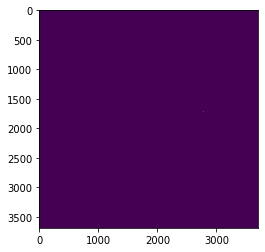

In [38]:
## Ploteo de poligonos rasterizados
#Posiblemente si los poligonos son demasiado pequeños no puedan ser persibidos
print("imagen ipcc 10")
plt.imshow(ImagesTrain[0]);# muestra la primera ejecucióm

## Itera las clasificaciones de los K-Fold y las guarda en un arreglo (kClasificaciones)

Se inicia una iteración los poligonos de un kfold y rasterizando la imagen anterior con los poligonos de kfold diferente al extraido, de manera que se generá una salida clasificada por cada kfold.Obteniendo finalmente un stack de imagenes clasificadas a partir de diferentes kfold.

In [39]:
start = datetime.datetime.now()  
print ('Comenzando Clasificacion: %s\n' % (start) )

kClasificaciones = []
# Parametros de la clasificación definidos para  la función Random Forest Regressor
maxDepth=2
RandState=0
NroEstimator=10

Comenzando Clasificacion: 2020-01-16 14:16:51.150129



In [40]:
for i in range(0,len(ImagesTrain)):
    print("Clasificando K-fold", i+1)
    labeled_pixels=ImagesTrain[i]
    is_train = np.nonzero(labeled_pixels)
    training_labels = labeled_pixels[is_train]
    bands_data=[]
    for band in bands: 
        bands_data.append(medians[band])
    bands_data = np.dstack(bands_data)
    print("bands_data")
    #print(bands_data)
    training_samples = bands_data[is_train]
    np.isfinite(training_samples)
    _msk=np.sum(np.isfinite(training_samples),1)>1
    training_samples= training_samples[_msk,:]
    training_labels=training_labels[_msk]
    #asignación de mascara valores nan por valor no data
    mask_nan=np.isnan(training_samples)
    training_samples[mask_nan]=-9999
    ##Clasificación Random Forest por regresión con los parametros definidos anteriormente
    classifier = RandomForestRegressor(max_depth= maxDepth, random_state=RandState,   n_estimators=NroEstimator)
    classifier.fit(training_samples, training_labels)
    rows, cols, n_bands = bands_data.shape
    n_samples = rows*cols
    flat_pixels = bands_data.reshape((n_samples, n_bands))
    #asignación de mascara valores nan por valor no data=-9999
    mask_nan=np.isnan(flat_pixels)
    flat_pixels[mask_nan]=-9999
    flat_pixels = bands_data.reshape((n_samples, n_bands))
    ##preparación de resultados en matriz con dimensiones igual a las consultadas al inicio del código
    result = classifier.predict(flat_pixels)
    classification = result.reshape((rows, cols))
    kClasificaciones.append(classification)

Clasificando K-fold 1
bands_data
Clasificando K-fold 2
bands_data
Clasificando K-fold 3
bands_data


### Preparación de la salida de medianas resultante de la clasificación 


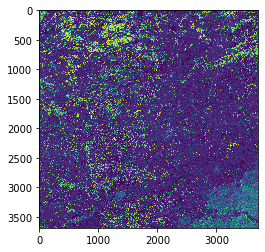

In [41]:
##Preparación de salida final 
kClasificaciones=np.asarray(kClasificaciones)
ImgResultado = np.zeros((rows, cols))
#Recorrer la matriz pixel a pixel
for l in range(0,cols):
    for j in range(0,rows): 
        dato = kClasificaciones[:,j,l]
        ## Cálculo de percentil 5 y 95 de los datos resultantes de cada set de datos correspondientes con las 7 clasificaciones anteriore resultantes, calculado pixel a pixel
        percent=np.percentile(dato,q=[5,95])
        #Cálculo de mediana para set de datos extrayendo los valores que se encuentre <5 y > 95 de los valores correspondientes a percentil, generando un solo pixel resultante.
        datoFinal = np.median(dato[np.logical_and(dato>percent[0],dato<percent[1])])
        #Resultado calculado a partir de la mediana del stack de datos clasificados donde se extraen  los valores extremos definidos anteriormente con los percentiles,proceso que se realiza pixel a pixel
        ImgResultado[j,l] = datoFinal

plt.imshow(ImgResultado)



In [42]:
ImgResultado

array([[24.68666667, 24.8       , 24.8       , ..., 24.68666667,
        24.8       , 24.68666667],
       [24.8       , 24.68666667, 24.8       , ..., 24.8       ,
        24.8       , 24.68666667],
       [24.8       , 24.8       , 24.4       , ..., 24.68666667,
        24.8       , 24.8       ],
       ...,
       [62.        , 42.74524476, 42.74524476, ..., 34.98615385,
        38.69524476, 34.98615385],
       [54.47857809, 50.76948718, 39.03615385, ..., 38.69524476,
        37.67510121, 42.74524476],
       [62.        , 54.47857809, 37.87464667, ..., 29.27964667,
        30.56666667, 34.98615385]])

### Validación de resultados obtenidos de la clasificación 

In [43]:
##Se emplea la función de validación de pixel clasificados comparando el valor estimado en la salida de  la clasificación con los valores asignados en el shapefile de entrenamiento empleados como insumo para la estimación de biomasa.
ImagesVal1 = []
k=10
pContKfold = 0
for K in pClasesName: # Recorre los  Kfold
    valid = ValidarClass(lyr, K, pAttributo, pAttrAGB, geo_transform, proj, kClasificaciones[pContKfold]) #rasteriza todos menos el kfold
    ImagesVal1.append(valid)
    k=k+1
    pContKfold += 1
    print(k)

Nro Poligonos para el Kfold 0.0  =  3
AGB: 61.6422 nroPol: 1
AGB en Shp:  61.6422 Media Calculada: 28.806666666666665
AGB: 29.0004 nroPol: 1
AGB en Shp:  29.0004 Media Calculada: 23.010714285714286
AGB: 27.7888 nroPol: 1
AGB en Shp:  27.7888 Media Calculada: 31.14114285714286
11
Nro Poligonos para el Kfold 5.0  =  1
AGB: 77.3851 nroPol: 1
AGB en Shp:  77.3851 Media Calculada: 20.494523166891586
12
Nro Poligonos para el Kfold 9.0  =  2
AGB: 18.7491 nroPol: 1
AGB en Shp:  18.7491 Media Calculada: 65.11504128327812
AGB: 18.0108 nroPol: 1
AGB en Shp:  18.0108 Media Calculada: 37.182273814702036
13


#### Salidas de cálculo de Error Biomasa

In [45]:
CImin=np.percentile(ImgResultado,q=[2.5])
print(CImin)
CImax=np.percentile(ImgResultado,q=[97.5])
print(CImax)
Ep=(CImax-CImin)/2
print(Ep)
Ep=Ep*Ep
print(Ep)
Em = (ImgResultado*10)/100
Ea = (ImgResultado*11)/100
Es = (ImgResultado*7.8)/100
Em = Em*Em
Ea = Ea*Ea
Es = Es*Es
E1= Em+Ea+Es
E1
Err=np.sqrt(E1)
print(Err)

[20.18321678]
[65.32]
[22.56839161]
[509.33229979]
[[ 4.14442007  4.16344657  4.16344657 ...  4.14442007  4.16344657
   4.14442007]
 [ 4.16344657  4.14442007  4.16344657 ...  4.16344657  4.16344657
   4.14442007]
 [ 4.16344657  4.16344657  4.09629421 ...  4.14442007  4.16344657
   4.16344657]
 ...
 [10.40861643  7.1761106   7.1761106  ...  5.87350735  6.49619291
   5.87350735]
 [ 9.14591327  8.52322772  6.55342504 ...  6.49619291  6.32493028
   7.1761106 ]
 [10.40861643  9.14591327  6.35843016 ...  4.91549373  5.13155982
   5.87350735]]


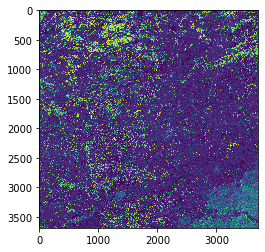

In [46]:
plt.imshow(Err)

### Preparar salida 

In [51]:
##Se llamará la función exportar por lo tanto deberá cambiar el nombre de manera que el algoritmo no sobreescriba archivos con este nombre
exportar("salida_test_2.tiff", ImgResultado, geo_transform, proj)

#### Cálculo de errores 

In [79]:
##Se llamará la función exportar por lo tanto deberá cambiar el nombre de manera que el algoritmo no sobreescriba archivos con este nombre
exportar("salida_test_e2.tiff", Err, geo_transform, proj)